In [ ]:
from collections import defaultdict, deque
import itertools
import numpy as np
import random
from enum import Enum
from typing import List, Tuple, Generator, Type
from dataclasses import dataclass
import time
import os
import bisect
from statistics import mean
from matplotlib import pyplot as plt
from torch.backends.cudnn import deterministic
from ConfigSpace import ConfigurationSpace
from smac import HyperparameterOptimizationFacade, Scenario
from scipy.stats import ttest_rel, wilcoxon
import re
import statistics
from scipy.stats import norm
import scipy
from copy import deepcopy


In [ ]:
def list_files_in_folder(folder_path):
    items = []
    try:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # Check if it's a file and not a directory (excluding .ipynb_checkpoints)
            if os.path.isfile(item_path) and '.ipynb_checkpoints' not in item and "GVNS" not in item and "VND" not in item and "GRASP" not in item:
                items.append(item_path)
        return items
    except FileNotFoundError:
        print(f"Folder not found: {folder_path}")
        return []

folder_path = "content/competition"
test_folder_path_small = "content/test/small"
test_folder_path_med = "content/test/med"
test_folder_path_med_large = "content/test/med_large"
test_folder_path_large = "content/test/large"

tuning_folder_path_small = "content/tuning/small"
tuning_folder_path_med = "content/tuning/medium"
tuning_folder_path_med_large = "content/tuning/medium_large"
tuning_folder_path_large = "content/tuning/large"


items = list_files_in_folder(folder_path)
items_test_small = list_files_in_folder(test_folder_path_small)
items_test_med = list_files_in_folder(test_folder_path_med)
items_test_med_large = list_files_in_folder(test_folder_path_med_large)
items_test_large = list_files_in_folder(test_folder_path_large)

items_tuning_small = list_files_in_folder(tuning_folder_path_small)
items_tuning_med = list_files_in_folder(tuning_folder_path_med)
items_tuning_med_large = list_files_in_folder(tuning_folder_path_med_large)
items_tuning_large = list_files_in_folder(tuning_folder_path_large)

class Graph:
    def __init__(self, U_size, V_size):
        self.U = list(range(1, U_size + 1))  # Nodes in fixed layer U
        self.V = list(range(U_size + 1, U_size + V_size + 1))  # Nodes in V
        self.edges = []  # List of edges (u, v, weight)
        self.constraints = defaultdict(list)  # Constraints as adjacency list for V
        self.in_degree = {v: 0 for v in self.V}   # Dictionary to store in-degree of nodes in V
        self.node_edges = defaultdict(list)  # Edges connected to each node
        self.solution_costs = {}  # Store costs for each solution

    def add_node_U(self, node):
        self.U.append(node)

    def add_node_V(self, node):
        self.V.append(node)
        self.in_degree[node] = 0  # Initialize in-degree for nodes in V

    def add_edge(self, u, v, weight):
        self.edges.append((u, v, weight))
        self.node_edges[u].append((v, weight))
        self.node_edges[v].append((u, weight))

    def add_constraint(self, v1, v2):
        self.constraints[v1].append(v2)
        self.in_degree[v2] += 1  # Update in-degree due to precedence constraint

def verify_solution(graph, solution: List[int]) -> bool:
        """Verify if a solution is valid."""
        # Check if all nodes are present exactly once
        if set(solution) != set(graph.V):
            return False

        # Check if constraints are satisfied
        positions = {node: idx for idx, node in enumerate(solution)}
        for v1 in graph.V:
            for v2 in graph.constraints[v1]:
                if positions[v1] >= positions[v2]:
                    return False
        return True

# Utility function for timing
class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.delta = self.end - self.start


def load_instance(filename):
    with open(filename, 'r') as file:
        U_size, V_size, C_size, E_size = map(int, file.readline().split())
        graph = Graph(U_size, V_size)

        # Read constraints section
        line = file.readline().strip()
        while line != "#constraints":
            line = file.readline().strip()

        for _ in range(C_size):
            v, v_prime = map(int, file.readline().split())
            graph.add_constraint(v, v_prime)

        # Read edges section
        line = file.readline().strip()
        while line != "#edges":
            line = file.readline().strip()

        for _ in range(E_size):
            u, v, weight = file.readline().split()
            graph.add_edge(int(u), int(v), float(weight))

    return graph

class BinaryIndexedTree:
    def __init__(self, size):
        self.size = size
        self.tree = [0] * (size + 1)

    def update(self, idx, val):
        idx += 1  # Convert to 1-based indexing
        while idx <= self.size:
            self.tree[idx] += val
            idx += idx & (-idx)

    def query(self, idx):
        idx += 1  # Convert to 1-based indexing
        total = 0
        while idx > 0:
            total += self.tree[idx]
            idx -= idx & (-idx)
        return total

def cost_function_bit(graph, permutation):
    """
    Alternative implementation using Binary Indexed Tree for very large graphs.
    Time complexity: O(E log E) where E is number of edges.

    Args:
        graph: Graph object containing edges and weights
        permutation: List representing the ordering of nodes in layer V

    Returns:
        float: Total cost of crossings
    """

    tuple_permutation = tuple(permutation)

    cost = graph.solution_costs.get(tuple_permutation, None)

    if cost is not None:
        return cost

    position = {node: idx for idx, node in enumerate(permutation)}
    max_pos = len(permutation)

    # Sort edges by u value
    edges = [(u, position[v], w) for u, v, w in graph.edges]
    edges.sort()

    total_cost = 0
    bit = BinaryIndexedTree(max_pos)
    weight_sum = BinaryIndexedTree(max_pos)

    # Process edges in order of increasing u
    for i, (u, pos_v, w) in enumerate(edges):
        # Count crossings with previous edges
        crossings = bit.query(max_pos - 1) - bit.query(pos_v)
        total_cost += crossings * w

        # Add contribution from weights of crossed edges
        weight_contribution = (weight_sum.query(max_pos - 1) -
                             weight_sum.query(pos_v))
        total_cost += weight_contribution

        # Update BITs
        bit.update(pos_v, 1)
        weight_sum.update(pos_v, w)

    graph.solution_costs[tuple_permutation] = total_cost

    return total_cost

In [ ]:
from typing import List, Optional

class DeterministicConstruction:
    """
    A deterministic construction algorithm using a fast heuristic based on
    U-layer positions and edge weights.
    """

    def __init__(self, graph: 'Graph'):
        self.graph = graph
        self.pi: List[int] = []
        self._precompute_node_metrics()

    def _precompute_node_metrics(self) -> None:
        """
        Precompute node metrics for efficient lookup:
        - Total edge weight per node
        - Average U-layer position of connected nodes
        """
        self.node_weights = defaultdict(int)
        self.avg_u_positions = defaultdict(float)
        self.u_connections = defaultdict(list)

        # Compute total weights and collect U positions
        for u, v, weight in self.graph.edges:
            self.node_weights[v] += weight
            self.u_connections[v].append(u)

        # Compute average U position
        for v in self.graph.V:
            if self.u_connections[v]:
                self.avg_u_positions[v] = sum(self.u_connections[v]) / len(self.u_connections[v])
            else:
                self.avg_u_positions[v] = len(self.graph.U) / 2  # Middle position if no connections

    def _get_best_candidate(self, candidates: deque, current_len: int) -> Optional[int]:
        """
        Select best candidate based on a simple scoring function that considers:
        1. Average position in U layer (prefer nodes whose U connections align with current position)
        2. Edge weights (prefer heavier edges)

        Args:
            candidates: Collection of candidate nodes
            current_len: Current length of placement

        Returns:
            Best candidate node or None if candidates is empty
        """
        if not candidates:
            return None

        # Target position in U layer based on current placement
        target_u_pos = (current_len / len(self.graph.V)) * len(self.graph.U)

        # Find node that best matches target position and has appropriate weight
        best_node = min(
            candidates,
            key=lambda v: (
                abs(self.avg_u_positions[v] - target_u_pos) * 0.9 +  # Position alignment
                -self.node_weights[v] * 0.1 # Weight consideration (negative to prefer higher weights)
            )
        )

        return best_node

    def verify_solution(self) -> bool:
        """Verify if the constructed solution satisfies all constraints."""
        positions = {node: idx for idx, node in enumerate(self.pi)}

        if set(self.pi) != set(self.graph.V):
            return False

        for v1 in self.graph.V:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False

        return True

    def greedy_construction(self) -> List[int]:
        """
        Construct a solution using a fast greedy approach.

        Returns:
            Ordered list of nodes representing the solution
        """
        self.pi = []
        in_degree = self.graph.in_degree.copy()
        candidates = deque([v for v in self.graph.V if in_degree[v] == 0])
        nodes_placed = 0

        while candidates:
            best_node = self._get_best_candidate(candidates, len(self.pi))
            if best_node is None:
                break

            self.pi.append(best_node)
            candidates.remove(best_node)
            nodes_placed += 1

            # Update in-degrees and add new candidates
            for v_next in self.graph.constraints[best_node]:
                in_degree[v_next] -= 1
                if in_degree[v_next] == 0:
                    candidates.append(v_next)

        if nodes_placed != len(self.graph.V):
            raise ValueError("Graph contains a cycle or is disconnected!")

        if not self.verify_solution():
            raise ValueError("Construction resulted in invalid solution!")

        return self.pi

In [ ]:
results = []  # Store (item_name, time, cost) for each solution
for item in items_test_small:
    graph = load_instance(item)
    with Timer() as t:
        solution = DeterministicConstruction(graph)
        ordering = solution.greedy_construction()
    cost = cost_function_bit(graph, ordering)  # Cost computation outside the timing block
    results.append((item, t.delta, cost))

print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
print("-" * 70)
for item, time_taken, cost in results:
    print(f"{item:<50} {time_taken:<10.6f} {cost:<10}")

Item                                               Time (s)   Cost      
----------------------------------------------------------------------
content/test/small/inst_50_4_00006                 0.000104   3184.0    
content/test/small/inst_50_4_00001                 0.000124   76753.0   
content/test/small/inst_50_4_00008                 0.000097   1542.0    
content/test/small/inst_50_4_00009                 0.000073   1471.0    
content/test/small/inst_50_4_00007                 0.000091   2694.0    
content/test/small/inst_50_4_00010                 0.000074   966.0     
content/test/small/inst_50_4_00002                 0.000082   26152.0   
content/test/small/inst_50_4_00005                 0.000080   4178.0    
content/test/small/inst_50_4_00004                 0.000072   7328.0    
content/test/small/inst_50_4_00003                 0.000085   13128.0   


# Task 1

## GA

In [ ]:
import abc


@dataclass
class GAParameters:
    population_size: int = 100
    generations: int = 100
    elite_size: int = 10
    tournament_size: int = 5
    mutation_rate: float = 0.3
    crossover_rate: float = 0.8
    constraint_penalty: float = 100000

    def __hash__(self):
        return hash((self.population_size, self.generations, self.elite_size, self.tournament_size, self.mutation_rate, self.crossover_rate, self.constraint_penalty))

    def __eq__(self, other):
        return hash(self) == hash(other) if isinstance(other, GAParameters) else False

    def __str__(self):
        return f"GAParameters(population_size={self.population_size}, generations={self.generations}, elite_size={self.elite_size}, tournament_size={self.tournament_size}, mutation_rate={self.mutation_rate}, crossover_rate={self.crossover_rate}, constraint_penalty={self.constraint_penalty})"

    def __repr__(self):
        return str(self)

class GeneticAlgorithm:
    def __init__(self, params: GAParameters = None, verbose: bool = False):
        self.params = params or GAParameters()
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.generation_stats = []
        self.verbose = verbose

    # Abstract methods
    @abc.abstractmethod
    def fitness(self, permutation: List[int]) -> float:
        pass

    @abc.abstractmethod
    def _init_population(self) -> List[List[int]]:
        pass

    @abc.abstractmethod
    def _generate_new_generation(self, population: List[any], fitnesses: List[float]) -> List[any]:
        pass

    def _tournament_selection(self, population: List[any], fitnesses: List[float]) -> any:
        """Tournament selection for parent selection"""
        tournament = random.sample(range(len(population)), min(self.params.tournament_size, len(population))) # Select k individuals
        winner = max(tournament, key=lambda i: fitnesses[i]) # Choose winner
        return population[winner]

    def run_generation(self, population: List[any]) -> Tuple[List[any], List[float]]:
        # Evaluate fitness of each individual
        fitnesses = [self.fitness(ind) for ind in population]

        # Store statistics
        gen_best_fitness = max(fitnesses)
        gen_avg_fitness = mean(fitnesses)
        self.generation_stats.append((gen_best_fitness, gen_avg_fitness))

        # Update best solution
        best_idx = fitnesses.index(gen_best_fitness)
        if fitnesses[best_idx] > self.best_fitness:
            self.best_fitness = fitnesses[best_idx]
            self.best_solution = population[best_idx]

        # Create next generation
        population = self._generate_new_generation(population, fitnesses)

        return population, fitnesses

    def run(self) -> Tuple[List[int], float]:
        """Execute the genetic algorithm"""
        # Initialize population
        population = self._init_population()

        for generation in range(self.params.generations):
            if self.verbose:
                print(f"Generation {generation + 1}/{self.params.generations}")
            population, _ = self.run_generation(population)

        return self.best_solution, - self.best_fitness


class GeneticAlgorithmMWCCP(GeneticAlgorithm):
    def __init__(self, graph: 'Graph', params: GAParameters = None, verbose: bool = True):
        self.graph = graph
        super().__init__(params, verbose=verbose)

    def fitness(self, V_order: List[int]) -> float:
        """Calculate fitness with penalty"""
        crossing_cost = cost_function_bit(self.graph, V_order)

        # Penalty for violated constraints
        penalty = self._calculate_constraint_violations(V_order) * self.params.constraint_penalty if self.params.constraint_penalty > 0 else 0
        return - crossing_cost - penalty

    def _calculate_constraint_violations(self, V_order: List[int]) -> int:
        """Count number of violated constraints"""
        violations = 0
        positions = {v: i for i, v in enumerate(V_order)}

        for v1 in V_order:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    violations += 1
        return violations

    def _order_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Implement Order Crossover (OX) operator"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))

        # Create a mapping for fast lookup
        p1_segment = set(parent1[start:end])

        # Initialize child with the segment from parent1
        child = [-1] * size
        child[start:end] = parent1[start:end]

        # Fill remaining positions with elements from parent2
        j = end
        for i in range(size):
            current = parent2[(end + i) % size]
            if current not in p1_segment:
                child[j % size] = current
                j += 1

        return child

    def _swap_mutation(self, individual: List[int]) -> List[int]:
        """Swap mutation with variable number of swaps"""
        if random.random() < self.params.mutation_rate:
            num_swaps = random.randint(1, max(1, len(individual) // 10))
            mutated = individual.copy()
            for _ in range(num_swaps):
                i, j = random.sample(range(len(mutated)), 2)
                mutated[i], mutated[j] = mutated[j], mutated[i]
            return mutated
        return individual

    def _repair_individual(self, individual: List[int]) -> List[int]:
        in_degree = self.graph.in_degree.copy()
        adjacency_list = self.graph.constraints
        index_map = {val: idx for idx, val in enumerate(individual)}

        queue = deque(v for v in self.graph.V if in_degree[v] == 0)
        repaired = []
        remaining = set(individual)

        while queue:
            candidates = [v for v in queue if v in remaining]
            if not candidates:
                candidates = list(remaining)

            v = min(candidates, key=index_map.get)
            repaired.append(v)
            remaining.remove(v)
            queue.remove(v)

            for neighbor in adjacency_list[v]:
                if neighbor in remaining:
                    in_degree[neighbor] -= 1
                    if in_degree[neighbor] == 0:
                        queue.append(neighbor)

        return repaired

    def is_valid(self, individual: List[int]) -> bool:
        """Check if an individual satisfies all constraints."""
        positions = {v: i for i, v in enumerate(individual)}
        for v1 in individual:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False
        return True

    def _init_population(self) -> List[List[int]]:
        """Initialize population"""
        population = [random.sample(self.graph.V, len(self.graph.V)) for _ in range(self.params.population_size)]
        population = [self._repair_individual(ind) if not self.is_valid(ind) else ind for ind in population]

        return population

    def _generate_new_generation(self, population: List[List[int]], fitnesses: List[float]) -> List[List[int]]:
        next_generation = []

        # Elitism
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
        next_generation.extend([population[i] for i in elite_indices[:self.params.elite_size]])

        # Generate offspring
        while len(next_generation) < self.params.population_size:
            if random.random() < self.params.crossover_rate:
                parent1 = self._tournament_selection(population, fitnesses)
                parent2 = self._tournament_selection(population, fitnesses)
                child = self._order_crossover(parent1, parent2)
            else:
                child = self._tournament_selection(population, fitnesses).copy()

            child = self._swap_mutation(child)
            child = self._repair_individual(child)
            next_generation.append(child)

        return next_generation

    def get_statistics(self) -> List[Tuple[float, float]]:
        """Return generation statistics"""
        return self.generation_stats

def solve_mwccp(graph: 'Graph', params: GAParameters = None) -> Tuple[List[int], float]:
    """Convenience function to solve MWCCP"""
    ga = GeneticAlgorithmMWCCP(graph, params)
    solution, cost = ga.run()
    return solution, cost

In [ ]:
import dataclasses

PARAMETER_RANGES = {
    "population_size": (10, 200),
    "generations": (10, 200),
    "elite_size": (0, 20),
    "tournament_size": (3, 20),
    "mutation_rate": (0.1, 0.5),
    "crossover_rate": (0.5, 1),
    "constraint_penalty": (100000, 1000000)
}

class GeneticAlgorithmParameterOptimization(GeneticAlgorithm):
    def __init__(self, instances_paths: List[str], params: GAParameters = None):
        self.instances = [load_instance(path) for path in instances_paths]
        params.constraint_penalty = 0  # Disable constraint penalty
        self.cache = {}
        super().__init__(params, verbose=True)

    def fitness(self, params: GAParameters) -> float:
        """Calculate fitness with penalty"""
        params_hash = hash(params)
        if params_hash in self.cache:
            return self.cache[params_hash]
        time_start = time.perf_counter()
        total_cost = 0
        for graph in self.instances:
            ga = GeneticAlgorithmMWCCP(graph, params, verbose=False)
            _, cost = ga.run()
            total_cost += cost
        time_end = time.perf_counter()
        time_taken = time_end - time_start
        fitness = - (total_cost + time_taken)
        self.cache[params_hash] = fitness

        return fitness

    def _init_population(self) -> List[GAParameters]:
        """Initialize population"""
        population = [GAParameters(
            population_size=random.randint(*PARAMETER_RANGES["population_size"]),
            generations=random.randint(*PARAMETER_RANGES["generations"]),
            elite_size=random.randint(*PARAMETER_RANGES["elite_size"]),
            tournament_size=random.randint(*PARAMETER_RANGES["tournament_size"]),
            mutation_rate=random.uniform(*PARAMETER_RANGES["mutation_rate"]),
            crossover_rate=random.uniform(*PARAMETER_RANGES["crossover_rate"]),
            constraint_penalty=random.randint(*PARAMETER_RANGES["constraint_penalty"])
        ) for _ in range(self.params.population_size)]

        return population

    def _mutate(self, individual: GAParameters) -> GAParameters:
        """Mutate an individual"""
        for field in PARAMETER_RANGES.keys():
            if random.random() < self.params.mutation_rate:
                value_range = (PARAMETER_RANGES[field][1] - PARAMETER_RANGES[field][0]) / 10
                old_value = getattr(individual, field)
                new_value = old_value + (random.uniform(-value_range, value_range) if isinstance(old_value, float) else random.randint(-int(value_range), int(value_range)))
                new_value = max(PARAMETER_RANGES[field][0], min(PARAMETER_RANGES[field][1], new_value))
                setattr(individual, field, new_value)
        return individual

    def weighted_random_probability(self, population: List[GAParameters], fitnesses: List[float]) -> GAParameters:
        min_fitness = min(fitnesses)
        normalized_fitnesses = [f - min_fitness for f in fitnesses]
        total_fitness = sum(normalized_fitnesses)
        probabilities = [f / total_fitness for f in normalized_fitnesses]

        return probabilities

    def _generate_new_generation(self, population: List[GAParameters], fitnesses: List[float]) -> List[GAParameters]:
        next_generation = []

        # Elitism
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
        next_generation.extend([population[i] for i in elite_indices[:self.params.elite_size]])

        # Generate offspring
        while len(next_generation) < self.params.population_size:
            probabilities = self.weighted_random_probability(population, fitnesses)
            if random.random() < self.params.crossover_rate:
                parent1, parent2 = random.choices(population, weights=probabilities, k=2)
                child = GAParameters(
                    population_size=parent1.population_size if random.random() < 0.5 else parent2.population_size,
                    generations=parent1.generations if random.random() < 0.5 else parent2.generations,
                    elite_size=parent1.elite_size if random.random() < 0.5 else parent2.elite_size,
                    tournament_size=parent1.tournament_size if random.random() < 0.5 else parent2.tournament_size,
                    mutation_rate=parent1.mutation_rate if random.random() < 0.5 else parent2.mutation_rate,
                    crossover_rate=parent1.crossover_rate if random.random() < 0.5 else parent2.crossover_rate,
                    constraint_penalty=parent1.constraint_penalty if random.random() < 0.5 else parent2.constraint_penalty
                )
            else:
                child = self._tournament_selection(population, fitnesses)

            child = self._mutate(child)
            next_generation.append(child)

        return next_generation

    def run_generation(self, population: List[any]) -> Tuple[List[any], List[float]]:
        best_params, best_fitness = super().run_generation(population)
        print(f"Parameters: {best_params}")
        print(f"Fitness: {best_fitness}")
        return best_params, best_fitness


In [ ]:
graph = load_instance(items_test_med[0])
cost_function_bit(graph, graph.V)

863420.0

In [ ]:
params = GAParameters(
    population_size=100,
    generations=200,
    elite_size=10,
    tournament_size=10,
    mutation_rate=0.2,
    crossover_rate=0.8,
    constraint_penalty=10000000
)
# Solve the problem
solution, cost = solve_mwccp(graph, params)
print(f"Minimum weighted crossing cost: {cost}")

Generation 1/200
Generation 2/200
Generation 3/200
Generation 4/200
Generation 5/200
Generation 6/200
Generation 7/200
Generation 8/200
Generation 9/200
Generation 10/200
Generation 11/200
Generation 12/200
Generation 13/200
Generation 14/200
Generation 15/200
Generation 16/200
Generation 17/200
Generation 18/200
Generation 19/200
Generation 20/200
Generation 21/200
Generation 22/200
Generation 23/200
Generation 24/200
Generation 25/200
Generation 26/200
Generation 27/200
Generation 28/200
Generation 29/200
Generation 30/200
Generation 31/200
Generation 32/200
Generation 33/200
Generation 34/200
Generation 35/200
Generation 36/200
Generation 37/200
Generation 38/200
Generation 39/200
Generation 40/200
Generation 41/200
Generation 42/200
Generation 43/200
Generation 44/200
Generation 45/200
Generation 46/200
Generation 47/200
Generation 48/200
Generation 49/200
Generation 50/200
Generation 51/200
Generation 52/200
Generation 53/200
Generation 54/200
Generation 55/200
Generation 56/200
G

In [ ]:
instance_name = os.path.basename(items[0])
with open(f"{instance_name}_ga.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, solution)) + "\n")

In [ ]:
# Optimize parameters
instances = [*items_test_small]
optimizer_params = GAParameters(
    population_size=20,
    generations=25,
    elite_size=3,
    tournament_size=5,
    mutation_rate=0.2,
    crossover_rate=0.8,
    constraint_penalty=0
)
ga_optimizer = GeneticAlgorithmParameterOptimization(instances, optimizer_params)
best_params, best_fitness = ga_optimizer.run()
print(f"Best parameters: {dataclasses.asdict(best_params)}")
print(f"Best fitness: {best_fitness}")

Generation 1/25
Parameters: [GAParameters(population_size=130, generations=191, elite_size=3, tournament_size=6, mutation_rate=0.134800602132532, crossover_rate=0.6523533249822608, constraint_penalty=235806), GAParameters(population_size=58, generations=192, elite_size=3, tournament_size=9, mutation_rate=0.4129629406535198, crossover_rate=0.9827076647806352, constraint_penalty=251533), GAParameters(population_size=134, generations=151, elite_size=5, tournament_size=10, mutation_rate=0.22867503601080968, crossover_rate=0.5435843580621875, constraint_penalty=334095), GAParameters(population_size=48, generations=155, elite_size=20, tournament_size=17, mutation_rate=0.10469598622186926, crossover_rate=0.6392350982856432, constraint_penalty=619334), GAParameters(population_size=83, generations=142, elite_size=9, tournament_size=3, mutation_rate=0.47479617124250445, crossover_rate=0.5964910106310068, constraint_penalty=562395), GAParameters(population_size=153, generations=142, elite_size=5,

KeyboardInterrupt: 

## Ant Colony Optimization

In [ ]:
class MaxMinAntSystem:
    def __init__(self, graph, alpha=1.0, beta=2.0, evaporation_rate=0.5, ant_count=10, iterations=100, tau_min=0.1, tau_max=10):
        self.graph = graph
        self.alpha = alpha  # Influence of pheromone
        self.beta = beta  # Influence of heuristic
        self.evaporation_rate = evaporation_rate
        self.ant_count = ant_count
        self.iterations = iterations
        self.tau_min = tau_min
        self.tau_max = tau_max

        # Map vertex IDs to indices for consistent matrix access
        self.vertex_to_index = {v: i for i, v in enumerate(self.graph.V)}
        self.index_to_vertex = {i: v for i, v in enumerate(self.graph.V)}

    def initialize_pheromone_and_heuristic(self):
        """Initialize pheromone and heuristic matrices."""
        num_vertices = len(self.graph.V)
        pheromone = np.ones((num_vertices, num_vertices), dtype=np.float64) * self.tau_max

        heuristic = np.zeros((num_vertices, num_vertices), dtype=np.float64)
        for v in self.graph.V:
            idx = self.vertex_to_index[v]
            # Use a heuristic metric
            heuristic[idx, :] = 1 / (1 + self.graph.in_degree[v])
            #neighbors = self.graph.node_edges[v]
            #avg_w = np.mean([neigh[1] for neigh in neighbors])
            #heuristic[idx, :] = 1 / (1 + avg_w)

        return pheromone, heuristic


    def construct_solution(self, pheromone, heuristic):
        """Construct a solution probabilistically."""
        num_vertices = len(self.graph.V)
        unvisited = set(self.graph.V)
        solution = []

        for position in range(num_vertices):
            probabilities = []
            for v in unvisited:
                idx = self.vertex_to_index[v]
                probabilities.append(
                    (pheromone[idx][position] ** self.alpha) * (heuristic[idx][position] ** self.beta)
                )
            probabilities = np.array(probabilities) / sum(probabilities)

            # Select vertex probabilistically
            vertex = random.choices(list(unvisited), weights=probabilities, k=1)[0]
            solution.append(vertex)
            unvisited.remove(vertex)

        if not self.is_valid(solution):
            solution = self.repair_solution(solution)

        return solution

    def repair_solution(self, solution):
        """Repair a solution to satisfy constraints."""
        in_degree = self.graph.in_degree.copy()
        adjacency_list = self.graph.constraints
        index_map = {val: idx for idx, val in enumerate(solution)}

        queue = deque(v for v in self.graph.V if in_degree[v] == 0)
        repaired = []
        remaining = set(solution)

        while queue:
            candidates = [v for v in queue if v in remaining]
            if not candidates:
                candidates = list(remaining)

            v = min(candidates, key=index_map.get)
            repaired.append(v)
            remaining.remove(v)
            queue.remove(v)

            for neighbor in adjacency_list[v]:
                if neighbor in remaining:
                    in_degree[neighbor] -= 1
                    if in_degree[neighbor] == 0:
                        queue.append(neighbor)

        return repaired

    def is_valid(self, solution):
        """Check if a solution satisfies all constraints."""
        positions = {v: i for i, v in enumerate(solution)}
        for v1 in solution:
            for v2 in self.graph.constraints[v1]:
                if positions[v1] > positions[v2]:
                    return False
        return True

    def update_pheromones(self, pheromone, best_solution, best_cost):
        """Update pheromone levels based on the best solution."""
        pheromone *= (1 - self.evaporation_rate)  # Evaporation

        for position, vertex in enumerate(best_solution):
            idx = self.vertex_to_index[vertex]
            pheromone[idx][position] += 1.0 / (1.0 + best_cost)

        # Apply pheromone bounds
        pheromone = np.clip(pheromone, self.tau_min, self.tau_max)

        return pheromone

    def ant_colony_optimization(self):
        """MMAS algorithm for MWCCP"""
        pheromone, heuristic = self.initialize_pheromone_and_heuristic()

        best_solution = None
        best_cost = float('inf')

        for _ in range(self.iterations):
            solutions = []
            fitnesses = []

            for _ in range(self.ant_count):
                solution = self.construct_solution(pheromone, heuristic)
                cost = cost_function_bit(self.graph, solution)
                solutions.append(solution)
                fitnesses.append(cost)

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

            # Update pheromone with only the global best solution
            pheromone = self.update_pheromones(pheromone, best_solution, best_cost)

            # Dynamically adjust tau_min and tau_max
            self.tau_max = 1.0 / (1.0 - self.evaporation_rate) * (1.0 / best_cost)
            self.tau_min = self.tau_max / (2 * len(self.graph.V))

        return best_solution, best_cost

In [ ]:
graph = load_instance(items_test_small[0])
cost_function_bit(graph, graph.V)

4645.0

In [ ]:
graph = load_instance(items_test_med[0])

aco = MaxMinAntSystem(graph, alpha=1.6, beta=1.4, evaporation_rate=0.3, ant_count=100, iterations=100)
solution, cost = aco.ant_colony_optimization()
print(f"Best solution: {solution}")
print(f"Minimum weighted crossing cost: {cost}")

Best solution: [188, 101, 133, 120, 128, 106, 103, 127, 140, 118, 108, 158, 184, 198, 196, 136, 173, 135, 149, 123, 138, 164, 114, 152, 117, 171, 111, 129, 156, 143, 132, 168, 104, 115, 116, 150, 125, 178, 107, 122, 146, 142, 130, 185, 160, 187, 124, 190, 126, 154, 139, 195, 159, 161, 163, 109, 170, 183, 200, 162, 137, 131, 157, 189, 155, 192, 166, 102, 119, 110, 193, 148, 194, 105, 181, 191, 151, 113, 186, 112, 179, 197, 167, 165, 141, 172, 145, 175, 180, 147, 169, 121, 134, 177, 182, 199, 176, 174, 153, 144]
Minimum weighted crossing cost: 761556.0


In [ ]:
instance_name = os.path.basename(items[1])
with open(f"{instance_name}_dt.txt", "w") as f:
    f.write(instance_name + "\n")
    f.write(" ".join(map(str, solution)) + "\n")

# Task 2: Parameter Optimization

In [ ]:
# Optimize the parameters using smac
instances = [*items_tuning_med]
instances_graphs = [load_instance(path) for path in instances]

# Define the parameter space for GA

ga_param_space = {
    "population_size": (20, 250),
    "generations": (10, 250),
    "elite_size": (0, 20),
    "tournament_size": (3, 30),
    "mutation_rate": (0.1, 0.6),
    "crossover_rate": (0.4, 1),
    "constraint_penalty": (10000, 1000000)
}

time_penalty_threshold = 60  # 1 minute time penalty threshold

def train_GA(params: dict, seed: int = 0) -> float:
    """Train and evaluate the GA algorithm with given parameters."""
    random.seed(seed)
    np.random.seed(seed)

    cumulative_fitness = 0
    timer_start = time.perf_counter()
    paramsGA = GAParameters(
        population_size=params["population_size"],
        generations=params["generations"],
        elite_size=params["elite_size"],
        tournament_size=params["tournament_size"],
        mutation_rate=params["mutation_rate"],
        crossover_rate=params["crossover_rate"],
        constraint_penalty=params["constraint_penalty"]
    )
    for graph in instances_graphs:
        ga = GeneticAlgorithmMWCCP(graph, paramsGA, verbose=False)
        _, best_fitness = ga.run()
        cumulative_fitness += best_fitness

    timer_end = time.perf_counter()

    time_taken = timer_end - timer_start

    time_penalty = 1 if time_taken <= time_penalty_threshold else time_taken / time_penalty_threshold

    return cumulative_fitness * time_penalty

In [ ]:
# Optimize the parameters using smac
configspace = ConfigurationSpace(ga_param_space)
scenario = Scenario(configspace, deterministic=True, n_trials=250, n_workers=10)

smac = HyperparameterOptimizationFacade(scenario, train_GA)
incumbent = smac.optimize()
print(incumbent)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 70 to 62 (max_ratio == 0.25).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64170 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 62 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][abstract_intensifier.py:516] Added config 9155b2 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 888c14 and rejected config 9155b2 as incumbent because it is not better than the incumbents on 1 instances:


2025-01-05 13:45:32,400 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-m01c4oko' (failed in <built-in function lstat>): [Errno 2] No such file or directory: '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-m01c4oko'
2025-01-05 13:45:32,408 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-2_hkmnb8' (failed in <built-in function lstat>): [Errno 2] No such file or directory: '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_output/dask-scratch-space/worker-2_hkmnb8'
2025-01-05 13:45:32,409 - distributed.diskutils - ERROR - Failed to remove '/Users/jurahostic/Documents/TUW/Heurustic Optimization Tehniques/heuristic_opt_hw1/smac3_o

[INFO][abstract_intensifier.py:595] Added config 1e6cfb and rejected config 888c14 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 08c7fa and rejected config 1e6cfb as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 04fed0 and rejected config 08c7fa as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config fbe72b and rejected config 04fed0 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][abstract_intensifier.py:595] Added config fb3070 and rejected config fbe72b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config c81374 and rejected config fb3070 as incumbe

In [ ]:
instances = [*items_tuning_med]
instances_graphs = [load_instance(path) for path in instances]

aco_param_space = {
    "alpha": (1.0, 2.0),
    "beta": (1.0, 2.0),
    "evaporation_rate": (0.1, 0.9),
    "ant_count": (20, 100),
    "iterations": (50, 250),
    "tau_min": (0.1, 1.0),
    "tau_max": (1.0, 10.0)
}

time_penalty_threshold = 60  # 8 minute time penalty threshold

def train_ACO(params: dict, seed: int = 0) -> float:
    """Train and evaluate the ACO algorithm with given parameters."""
    random.seed(seed)
    np.random.seed(seed)

    cumulative_fitness = 0
    timer_start = time.perf_counter()
    for graph in instances_graphs:
        aco = MaxMinAntSystem(graph, **params)
        _, best_fitness = aco.ant_colony_optimization()
        cumulative_fitness += best_fitness
    timer_end = time.perf_counter()

    time_taken = timer_end - timer_start
    time_penalty = 1 if time_taken <= time_penalty_threshold else time_taken / time_penalty_threshold

    return cumulative_fitness * time_penalty

In [ ]:
configspace = ConfigurationSpace(aco_param_space)
scenario = Scenario(configspace, deterministic=True, n_trials=250, n_workers=6)

smac = HyperparameterOptimizationFacade(scenario, train_ACO)
incumbent = smac.optimize()
print(incumbent)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 70 to 62 (max_ratio == 0.25).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51728 instead
  warnings.warn(


[INFO][abstract_initial_design.py:147] Using 62 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][smbo.py:320] Finished 0 trials.
[INFO][abstract_intensifier.py:516] Added config 2ef302 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config c21ff2 and rejected config 2ef302 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 9b845d and rejected config c21ff2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][abstract_intensifi

## Effects of Paramaters on algorithm speed and cost

### GA

In [ ]:
# Final parameters
GA_params = GAParameters(
    population_size=40,
    generations=150,
    elite_size=13,
    tournament_size=25,
    mutation_rate=0.255,
    crossover_rate=0.79,
    constraint_penalty=213178
)

ACO_params = {
    'alpha': 1.87,
    'beta': 1.07,
    'evaporation_rate': 0.69,
    'ant_count': 22,
    'iterations': 55,
    'tau_min': 0.51,
    'tau_max': 7.85
}

In [ ]:
instances = [*items_tuning_med]
instances_graphs = [load_instance(path) for path in instances]

file_dir = "paramaters_effect_ga"

if not os.path.exists(file_dir):
    os.makedirs(file_dir)

def graph_parameters_effect(params, param_name, param_values, repeat=3):
    results = []
    for value in param_values:
        params_copy = deepcopy(params)
        print(f"Testing {param_name} = {value}")
        setattr(params_copy, param_name, value)
        cumulative_fitness = 0
        cumulative_time = 0
        for graph in instances_graphs:
            for _ in range(repeat):
                ga = GeneticAlgorithmMWCCP(graph, params_copy, verbose=False)
                with Timer() as t:
                    _, best_fitness = ga.run()
                cumulative_fitness += best_fitness
                cumulative_time += t.delta
        results.append((value, cumulative_fitness / repeat, cumulative_time / repeat))


    plt.figure(figsize=(12, 4))

    # Line graph for cost
    original_value = getattr(params, param_name)
    plt.subplot(1, 2, 1)
    plt.plot(values, [f for _, f, _ in results], marker='o', color='blue', label='Cost')
    if original_value in values:
        idx = values.index(original_value)
        plt.scatter(values[idx], results[idx][1], color='red', zorder=5, label='Selected Value')
    plt.xticks(values)
    plt.xlabel(param_name)
    plt.ylabel("Cost")
    plt.title(f"Effect of {param_name} on Cost")

    # Line graph for time
    plt.subplot(1, 2, 2)
    plt.plot(values, [t for _, _, t in results], marker='o', color='blue', label='Time')
    if original_value in values:
        idx = values.index(original_value)
        plt.scatter(values[idx], results[idx][2], color='red', zorder=5, label='Selected Value')
    plt.xticks(values)
    plt.xlabel(param_name)
    plt.ylabel("Time (s)")
    plt.title(f"Effect of {param_name} on Time")

    plt.tight_layout()
    plt.show()

    # Save the results to a file
    with open(f"{file_dir}/{param_name}.txt", "w") as f:
        f.write(f"Results for {param_name}\n")
        for value, cost, time in results:
            f.write(f"{value} - {cost:.2f} - {time:.2f}\n")

    return results

Testing population_size
Testing population_size = 20
Testing population_size = 40
Testing population_size = 80
Testing population_size = 150
Testing population_size = 200


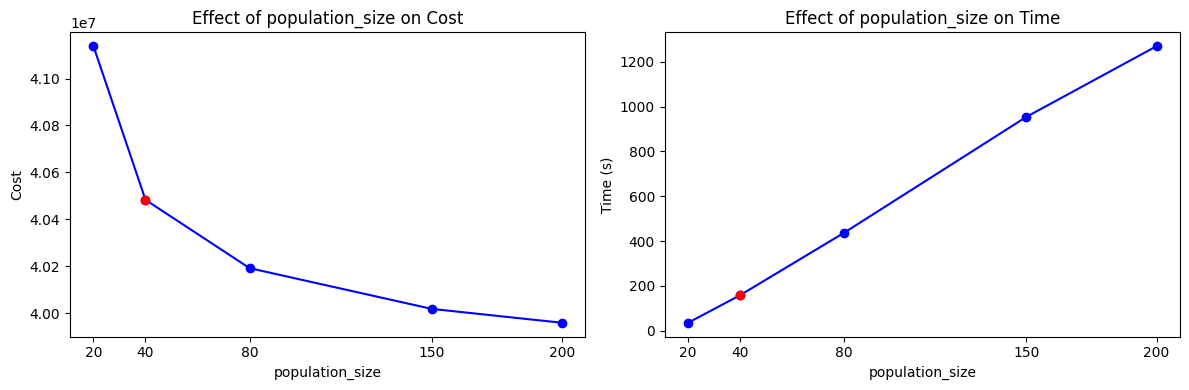

Testing generations
Testing generations = 10
Testing generations = 40
Testing generations = 100
Testing generations = 150
Testing generations = 200


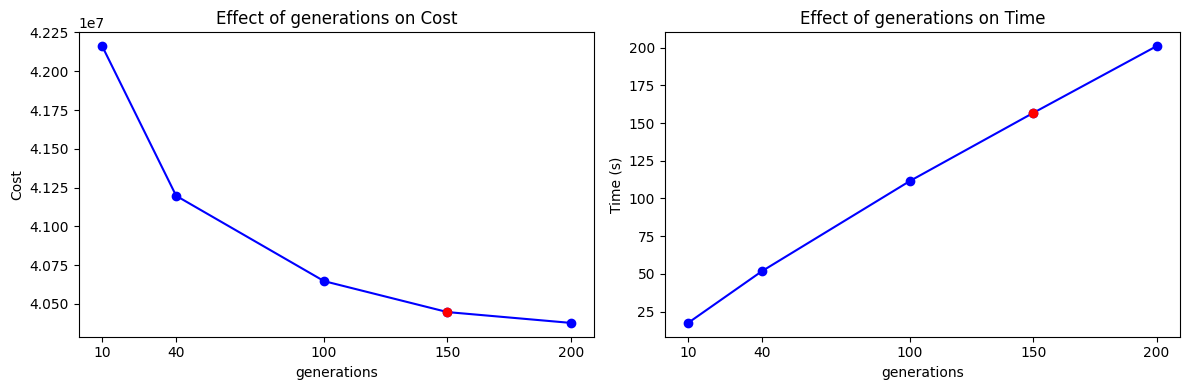

Testing elite_size
Testing elite_size = 3
Testing elite_size = 5
Testing elite_size = 10
Testing elite_size = 13
Testing elite_size = 15
Testing elite_size = 20


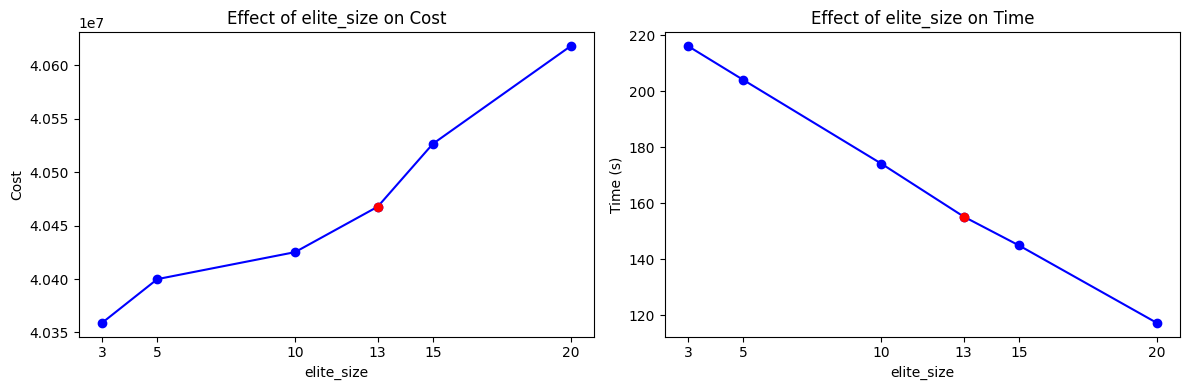

Testing tournament_size
Testing tournament_size = 3
Testing tournament_size = 5
Testing tournament_size = 10
Testing tournament_size = 15
Testing tournament_size = 20
Testing tournament_size = 25
Testing tournament_size = 30


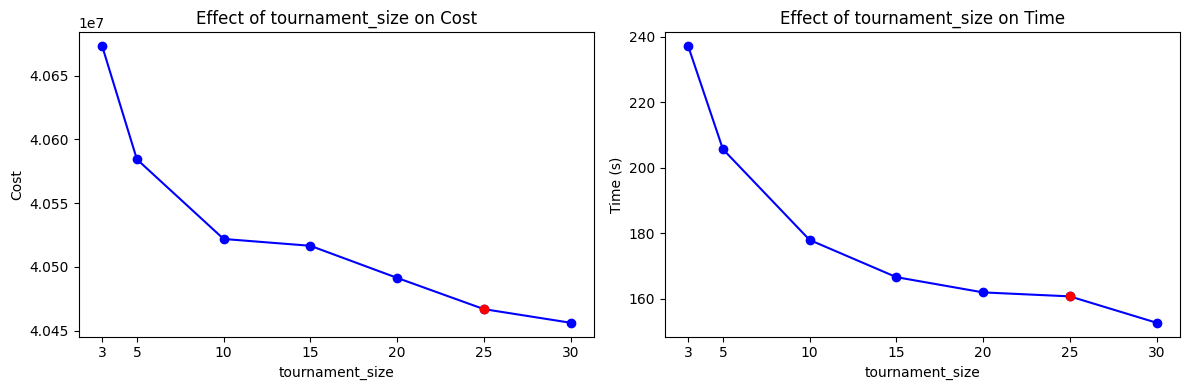

Testing mutation_rate
Testing mutation_rate = 0.1
Testing mutation_rate = 0.2
Testing mutation_rate = 0.255
Testing mutation_rate = 0.3
Testing mutation_rate = 0.4
Testing mutation_rate = 0.5


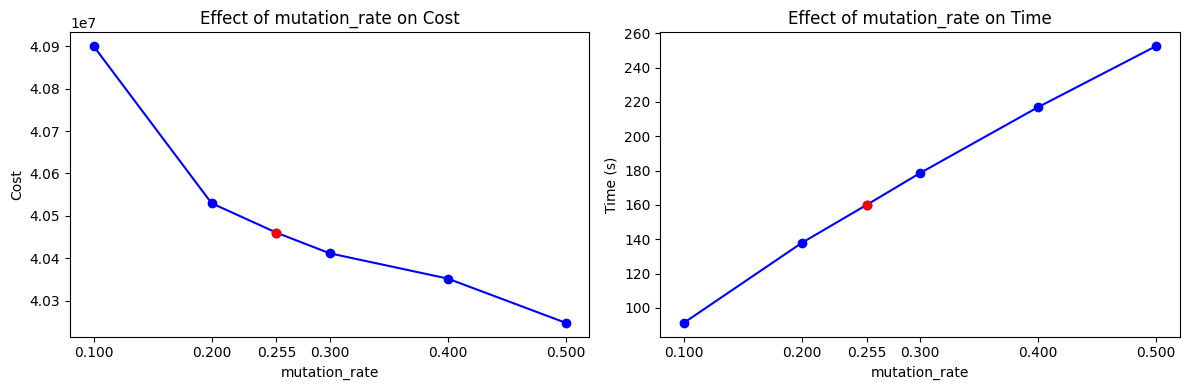

Testing crossover_rate
Testing crossover_rate = 0.5
Testing crossover_rate = 0.6
Testing crossover_rate = 0.7
Testing crossover_rate = 0.79
Testing crossover_rate = 0.9
Testing crossover_rate = 1.0


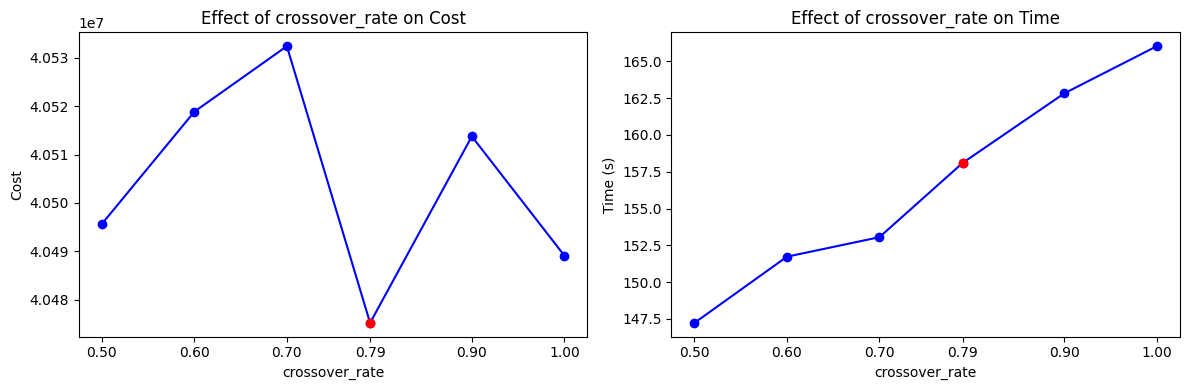

Testing constraint_penalty
Testing constraint_penalty = 100000
Testing constraint_penalty = 213178
Testing constraint_penalty = 500000
Testing constraint_penalty = 1000000


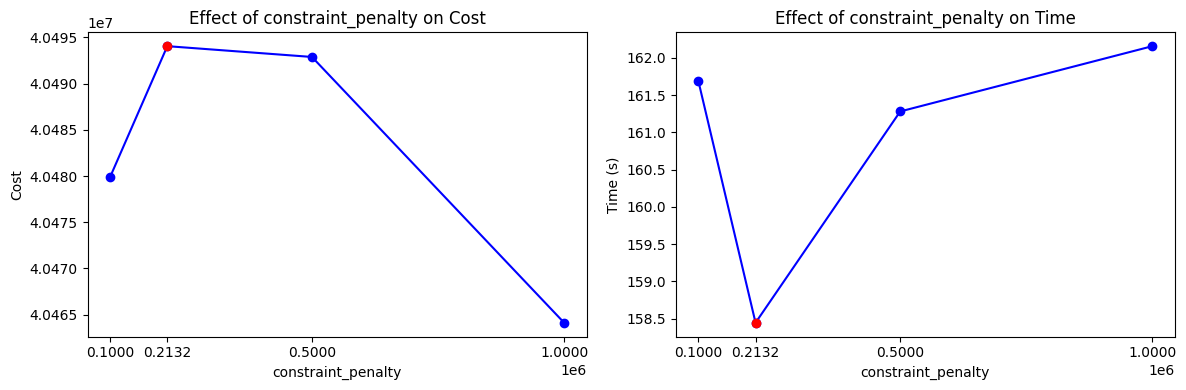

In [ ]:
paramater_values = {
    "population_size": [20, 40, 80, 150, 200],
    "generations": [10, 40, 100, 150, 200],
    "elite_size": [3, 5, 10, 13, 15, 20],
    "tournament_size": [3, 5, 10, 15, 20, 25, 30],
    "mutation_rate": [0.1, 0.2, 0.255, 0.3, 0.4, 0.5],
    "crossover_rate": [0.5, 0.6, 0.7, 0.79, 0.9, 1.0],
    "constraint_penalty": [100000, 213178, 500000, 1000000]
}

for param_name, values in paramater_values.items():
    print(f"Testing {param_name}")
    graph_parameters_effect(GA_params, param_name, values)


### ACO

In [ ]:
instances = [*items_tuning_med]
instances_graphs = [load_instance(path) for path in instances]

file_dir = "paramaters_effect_aco"

if not os.path.exists(file_dir):
    os.makedirs(file_dir)

def graph_parameters_effect(params, param_name, param_values, repeat=3):
    results = []
    for value in param_values:
        params_copy = deepcopy(params)
        print(f"Testing {param_name} = {value}")
        params_copy[param_name] = value
        cumulative_fitness = 0
        cumulative_time = 0
        for graph in instances_graphs:
            for _ in range(repeat):
                aoc = MaxMinAntSystem(graph, **params_copy)
                with Timer() as t:
                    _, best_fitness = aoc.ant_colony_optimization()
                cumulative_fitness += best_fitness
                cumulative_time += t.delta
        results.append((value, cumulative_fitness / repeat, cumulative_time / repeat))


    plt.figure(figsize=(12, 4))

    # Line graph for cost
    original_value = params[param_name]
    plt.subplot(1, 2, 1)
    plt.plot(values, [f for _, f, _ in results], marker='o', color='blue', label='Cost')
    if original_value in values:
        idx = values.index(original_value)
        plt.scatter(values[idx], results[idx][1], color='red', zorder=5, label='Selected Value')
    plt.xticks(values)
    plt.xlabel(param_name)
    plt.ylabel("Cost")
    plt.title(f"Effect of {param_name} on Cost")

    # Line graph for time
    plt.subplot(1, 2, 2)
    plt.plot(values, [t for _, _, t in results], marker='o', color='blue', label='Time')
    if original_value in values:
        idx = values.index(original_value)
        plt.scatter(values[idx], results[idx][2], color='red', zorder=5, label='Selected Value')
    plt.xticks(values)
    plt.xlabel(param_name)
    plt.ylabel("Time (s)")
    plt.title(f"Effect of {param_name} on Time")

    plt.tight_layout()
    plt.show()

    # Save the results to a file
    with open(f"{file_dir}/{param_name}.txt", "w") as f:
        f.write(f"Results for {param_name}\n")
        for value, cost, time in results:
            f.write(f"{value} - {cost:.2f} - {time:.2f}\n")

    return results

Testing alpha
Testing alpha = 1.0
Testing alpha = 1.5
Testing alpha = 1.87
Testing alpha = 2.0


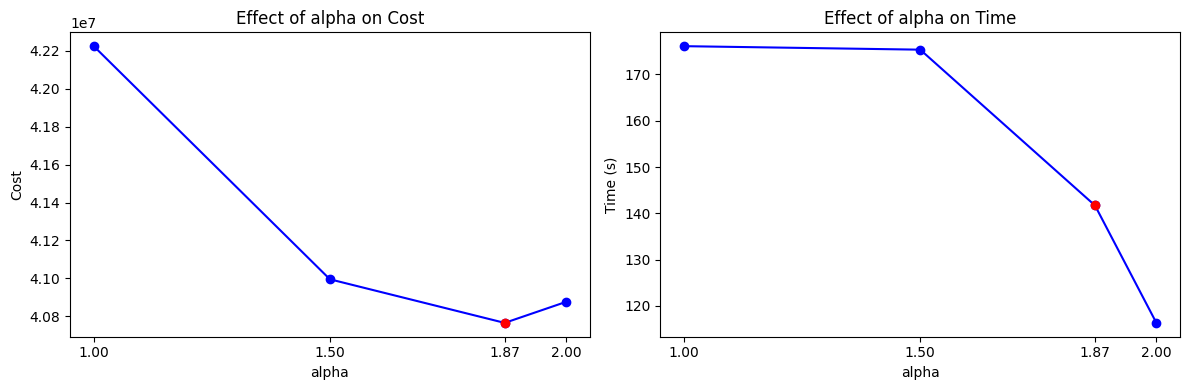

Testing beta
Testing beta = 1.0
Testing beta = 1.07
Testing beta = 1.5
Testing beta = 2.0


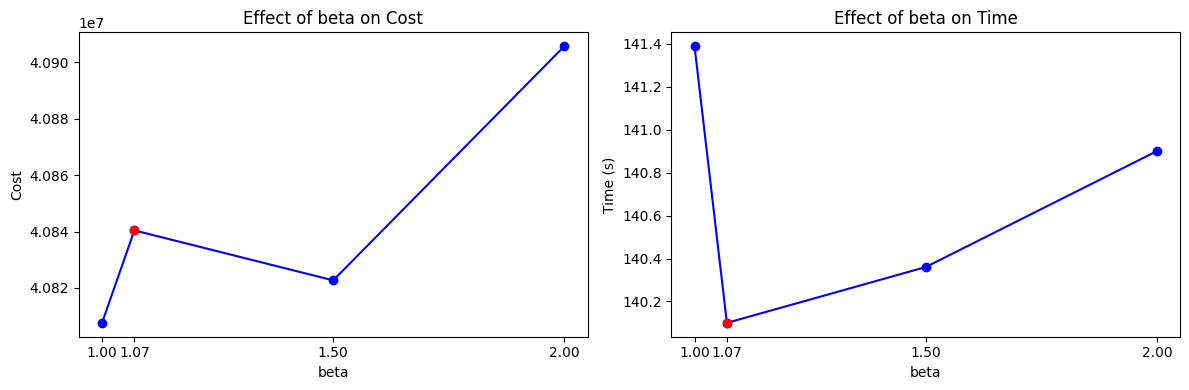

Testing evaporation_rate
Testing evaporation_rate = 0.1
Testing evaporation_rate = 0.3
Testing evaporation_rate = 0.5
Testing evaporation_rate = 0.69
Testing evaporation_rate = 0.9


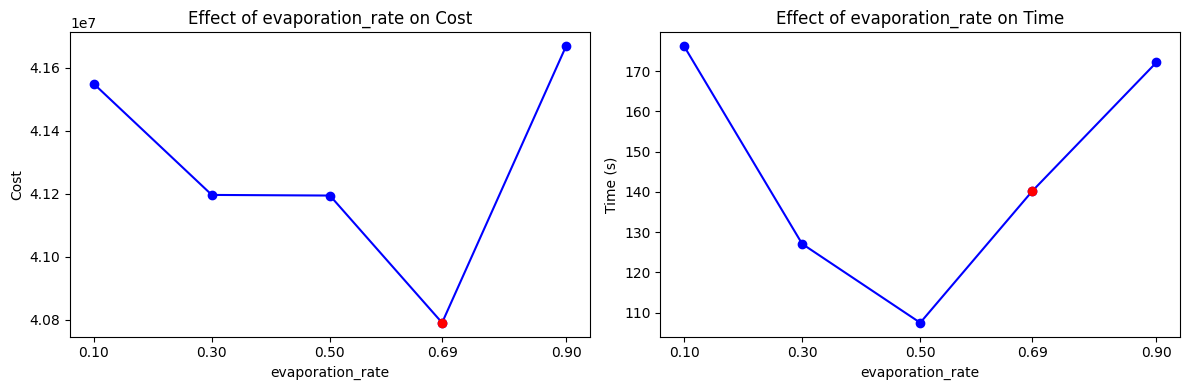

Testing ant_count
Testing ant_count = 15
Testing ant_count = 22
Testing ant_count = 50
Testing ant_count = 75
Testing ant_count = 100


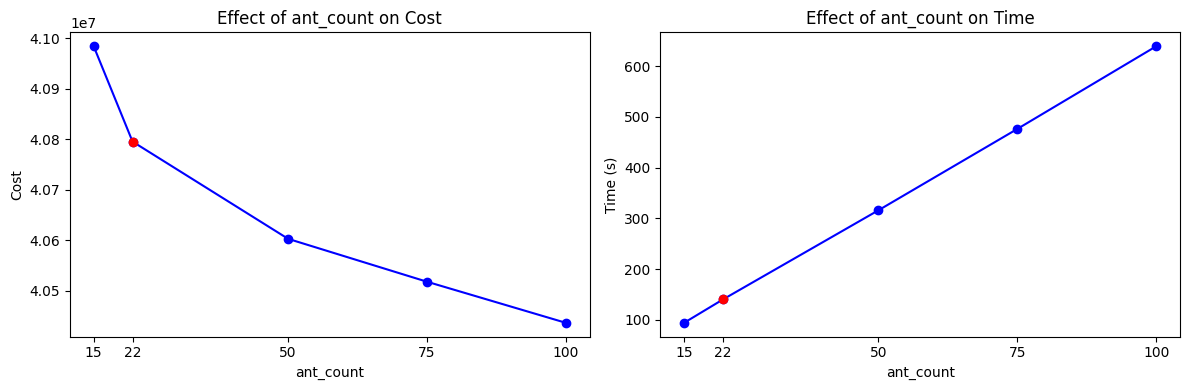

Testing iterations
Testing iterations = 25
Testing iterations = 55
Testing iterations = 100
Testing iterations = 150
Testing iterations = 200
Testing iterations = 250


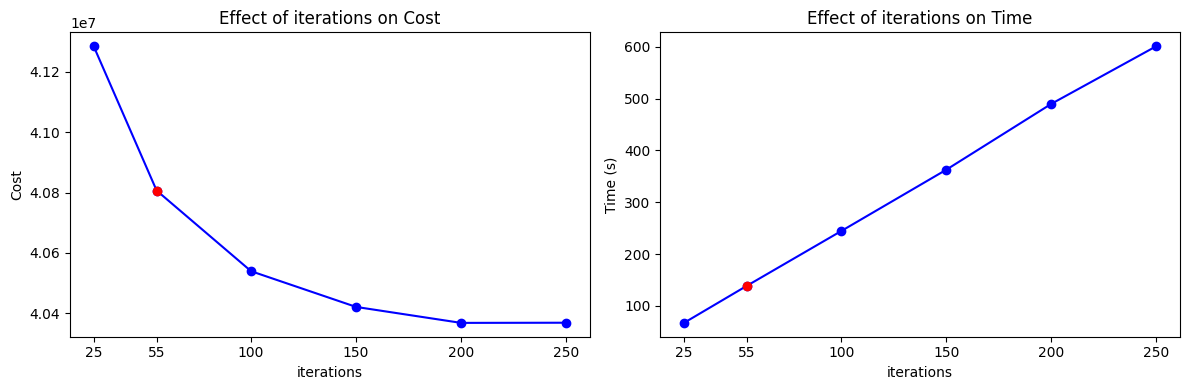

Testing tau_min
Testing tau_min = 0.1
Testing tau_min = 0.3
Testing tau_min = 0.51
Testing tau_min = 0.7
Testing tau_min = 1.0


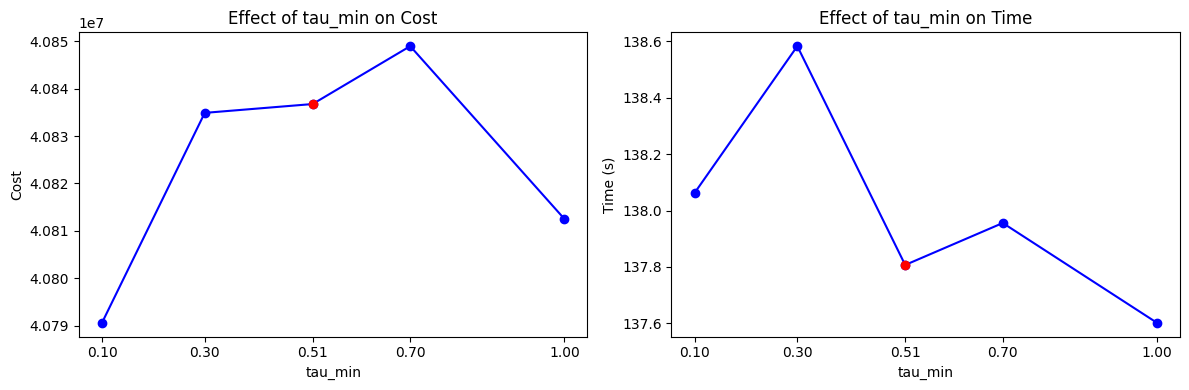

Testing tau_max
Testing tau_max = 1.0
Testing tau_max = 3.0
Testing tau_max = 7.85
Testing tau_max = 10.0


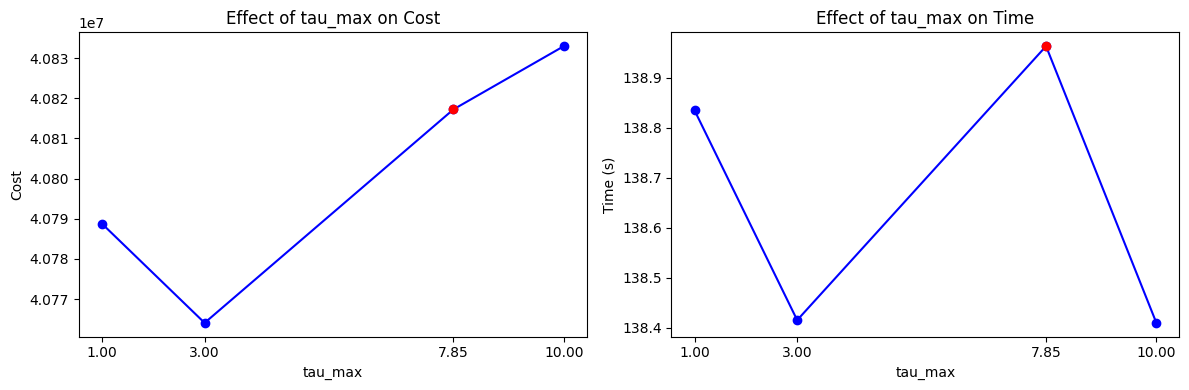

In [ ]:
paramater_values = {
    "alpha": [1.0, 1.5, 1.87, 2.0],
    "beta": [1.0, 1.07, 1.5, 2.0],
    "evaporation_rate": [0.1, 0.3, 0.5, 0.69, 0.9],
    "ant_count": [15, 22, 50, 75, 100],
    "iterations": [25, 55, 100, 150, 200, 250],
    "tau_min": [0.1, 0.3, 0.51, 0.7, 1.0],
    "tau_max": [1.0, 3.0, 7.85, 10.0]
}

for param_name, values in paramater_values.items():
    print(f"Testing {param_name}")
    graph_parameters_effect(ACO_params, param_name, values)

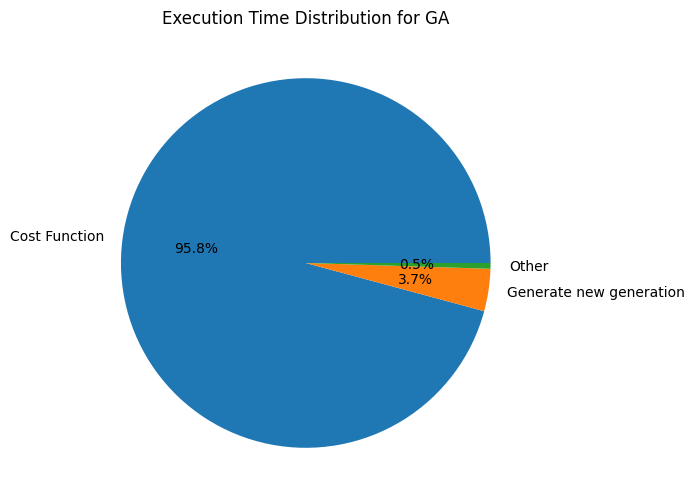

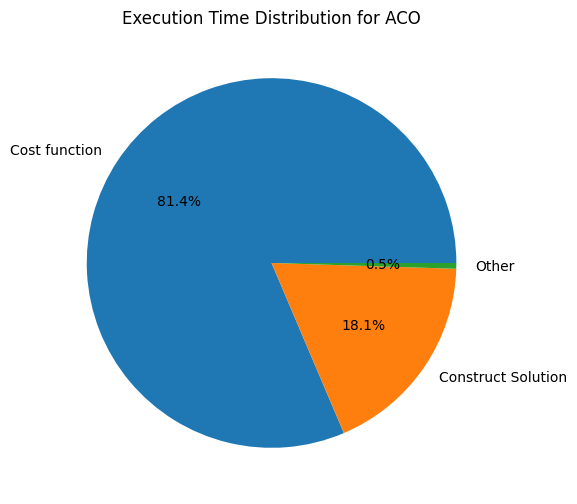

In [ ]:
# Profiling pie chart
GA_results = {
    "Cost Function": 95.8,
    "Generate new generation": 3.7,
    "Other": 0.5
}
ACO_results = {
    "Cost function": 81.4,
    "Construct Solution": 18.1,
    "Other": 0.5
}
#Graph GA
plt.figure(figsize=(12, 6))
# Pie chart
plt.pie(GA_results.values(), labels=GA_results.keys(), autopct='%1.1f%%', startangle=0)
plt.title("Execution Time Distribution for GA")
plt.show()


# Graph ACO
plt.figure(figsize=(12, 6))
# Pie chart
plt.pie(ACO_results.values(), labels=ACO_results.keys(), autopct='%1.1f%%', startangle=0)
plt.title("Execution Time Distribution for ACO")
plt.show()

## Testing algorithms

In [ ]:
def load_instances(items):
    return [(path, load_instance(path)) for path in items]

instances = {
    "small": load_instances(items_test_small),
    "medium": load_instances(items_test_med),
    # "medium_large": load_instances(items_test_med_large),
    # "large": load_instances(items_test_large)
}

In [ ]:
from copy import deepcopy

# 'constraint_penalty': 213178,
#   'crossover_rate': 0.7906358312146,
#   'elite_size': 13,
#   'generations': 149,
#   'mutation_rate': 0.2555087083201,
#   'population_size': 40,
#   'tournament_size': 25,

GA_params = GAParameters(
    population_size=40,
    generations=150,
    elite_size=13,
    tournament_size=25,
    mutation_rate=0.255,
    crossover_rate=0.79,
    constraint_penalty=213178
)

save_dir = "results_ga"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

repeat = 30

for name, items in instances.items():
    results = []
    print(f"Running GA on {name} instances")
    save_path = f"{save_dir}/{name}.txt"
    if not os.path.exists(save_path):
        with open(save_path, "w") as f:
            f.write(f"GA Parameters: {GA_params}\n")

    for i, (path, graph) in enumerate(items):
        iteration_results = []
        print(f"Instance {i + 1}/{len(items)}")
        for iter in range(repeat):
            print(f"Repeat {iter + 1}/{repeat}")
            graph_copy = deepcopy(graph)
            with Timer() as t:
                solution = GeneticAlgorithmMWCCP(graph_copy, GA_params, verbose=False)
                ordering, cost = solution.run()  # Cost computation outside the timing block
            results.append((path, t.delta, cost))
            print(f"{path} - {t.delta:.2f}s - {cost}")
            iteration_results.append((path, t.delta, cost, ordering))

        with open(save_path, "a") as f:
            for path, time_taken, cost, _ in iteration_results:
                f.write(f"{path} - {time_taken:.2f} - {cost}\n")

            average_cost = sum(cost for _, _, cost, _ in iteration_results) / repeat
            std_cost = np.std([cost for _, _, cost, _ in iteration_results])
            f.write(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}\n")

            average_time = sum(time_taken for _, time_taken, _, _ in iteration_results) / repeat
            std_time = np.std([time_taken for _, time_taken, _, _ in iteration_results])
            f.write(f"Average time: {average_time:.2f} - Std: {std_time:.2f}\n")

    print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
    print("-" * 70)

Running GA on small instances
Instance 1/10
Repeat 1/30
content/test/small/inst_50_4_00006 - 0.96s - 2984.0
Repeat 2/30
content/test/small/inst_50_4_00006 - 0.90s - 2973.0
Repeat 3/30
content/test/small/inst_50_4_00006 - 0.91s - 2985.0
Repeat 4/30
content/test/small/inst_50_4_00006 - 0.91s - 2985.0
Repeat 5/30
content/test/small/inst_50_4_00006 - 0.83s - 2977.0
Repeat 6/30
content/test/small/inst_50_4_00006 - 0.86s - 2970.0
Repeat 7/30
content/test/small/inst_50_4_00006 - 0.84s - 2973.0
Repeat 8/30
content/test/small/inst_50_4_00006 - 0.88s - 2977.0
Repeat 9/30
content/test/small/inst_50_4_00006 - 0.94s - 2963.0
Repeat 10/30
content/test/small/inst_50_4_00006 - 0.96s - 2970.0
Repeat 11/30
content/test/small/inst_50_4_00006 - 0.86s - 2978.0
Repeat 12/30
content/test/small/inst_50_4_00006 - 0.85s - 2967.0
Repeat 13/30
content/test/small/inst_50_4_00006 - 0.85s - 2970.0
Repeat 14/30
content/test/small/inst_50_4_00006 - 0.87s - 2965.0
Repeat 15/30
content/test/small/inst_50_4_00006 - 0.89s

In [ ]:
# Configuration(values={
#   'alpha': 1.8699668615412,
#   'ant_count': 22,
#   'beta': 1.0702607933214,
#   'evaporation_rate': 0.6922705509118,
#   'iterations': 55,
#   'tau_max': 7.8543738109695,
#   'tau_min': 0.505812093858,
# })

ACO_params = {
    'alpha': 1.87,
    'beta': 1.07,
    'evaporation_rate': 0.69,
    'ant_count': 22,
    'iterations': 55,
    'tau_min': 0.51,
    'tau_max': 7.85
}

save_dir = "results_aco"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

repeat = 30

for name, items in instances.items():
    results = []
    print(f"Running ACO on {name} instances")
    save_path = f"{save_dir}/{name}.txt"
    if not os.path.exists(save_path):
        with open(save_path, "w") as f:
            f.write(f"ACO Parameters: {ACO_params}\n")

    for i, (path, graph) in enumerate(items):
        iteration_results = []
        print(f"Instance {i + 1}/{len(items)}")
        for iter in range(repeat):
            print(f"Repeat {iter + 1}/{repeat}")
            graph_copy = deepcopy(graph)
            with Timer() as t:
                solution = MaxMinAntSystem(graph_copy, **ACO_params)
                ordering, cost = solution.ant_colony_optimization()  # Cost computation outside the timing block
            results.append((path, t.delta, cost))
            print(f"{path} - {t.delta:.2f}s - {cost}")
            iteration_results.append((path, t.delta, cost, ordering))

        with open(save_path, "a") as f:
            for path, time_taken, cost, _ in iteration_results:
                f.write(f"{path} - {time_taken:.2f} - {cost}\n")

            average_cost = sum(cost for _, _, cost, _ in iteration_results) / repeat
            std_cost = np.std([cost for _, _, cost, _ in iteration_results])
            f.write(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}\n")

            average_time = sum(time_taken for _, time_taken, _, _ in iteration_results) / repeat
            std_time = np.std([time_taken for _, time_taken, _, _ in iteration_results])
            f.write(f"Average time: {average_time:.2f} - Std: {std_time:.2f}\n")

    print(f"{'Item':<50} {'Time (s)':<10} {'Cost':<10}")
    print("-" * 70)

Running ACO on small instances
Instance 1/10
Repeat 1/30
content/test/small/inst_50_4_00006 - 0.72s - 3077.0
Repeat 2/30
content/test/small/inst_50_4_00006 - 0.65s - 3080.0
Repeat 3/30
content/test/small/inst_50_4_00006 - 0.65s - 3078.0
Repeat 4/30
content/test/small/inst_50_4_00006 - 0.63s - 3035.0
Repeat 5/30
content/test/small/inst_50_4_00006 - 0.66s - 3064.0
Repeat 6/30
content/test/small/inst_50_4_00006 - 0.68s - 3119.0
Repeat 7/30
content/test/small/inst_50_4_00006 - 0.68s - 3033.0
Repeat 8/30
content/test/small/inst_50_4_00006 - 0.68s - 3071.0
Repeat 9/30
content/test/small/inst_50_4_00006 - 0.66s - 3188.0
Repeat 10/30
content/test/small/inst_50_4_00006 - 0.66s - 3153.0
Repeat 11/30
content/test/small/inst_50_4_00006 - 0.67s - 3053.0
Repeat 12/30
content/test/small/inst_50_4_00006 - 0.67s - 3099.0
Repeat 13/30
content/test/small/inst_50_4_00006 - 0.68s - 3182.0
Repeat 14/30
content/test/small/inst_50_4_00006 - 0.69s - 3071.0
Repeat 15/30
content/test/small/inst_50_4_00006 - 0.66

In [ ]:
paths_to_rerun = []
instances_to_rerun = load_instances(paths_to_rerun)

repeat = 5

for path, graph in instances_to_rerun:
    print(f"Running ACO on {path}")
    results = []
    for i in range(repeat):
        print(f"Repeat {i + 1}/{repeat}")
        graph_copy = deepcopy(graph)
        with Timer() as t:
            solution = MaxMinAntSystem(graph_copy, **ACO_params)
            ordering, cost = solution.ant_colony_optimization()  # Cost computation outside the timing block
        results.append((path, t.delta, cost))
        print(f"{path} - {t.delta:.2f}s - {cost}")

    average_cost = sum(cost for _, _, cost in results) / repeat
    std_cost = np.std([cost for _, _, cost in results])
    print(f"Average cost: {average_cost:.2f} - Std: {std_cost:.2f}")
    average_time = sum(time_taken for _, time_taken, _ in results) / repeat
    std_time = np.std([time_taken for _, time_taken, _ in results])
    print(f"Average time: {average_time:.2f} - Std: {std_time:.2f}")